[View in Colaboratory](https://colab.research.google.com/github/tushardhamani/industrial-real-estate-prediction/blob/master/CassTrucking.ipynb)

IMPORT

In [0]:
import requests
import json
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import keras
import seaborn as sns
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from sklearn.preprocessing import Normalizer
import h5py
from keras import backend as K
import io

API DEF

In [0]:
API_ENDPOINT = "https://gmaatest.azurewebsites.net/api/HttpTriggerCSharp1?code=COXmk9ou6Mr8/dUCYj045SaeNm6jCkPzJ3ilU/dCiTvNcFNQax4BMQ=="
QUAND_CASS = "https://www.quandl.com/api/v3/datasets/CASS/CFI.json?api_key=Kcxxx_nHsCG7xiM_yKgY"
QUAND_PRR = "https://www.quandl.com/api/v3/datasets/ZILLOW/M1_PRRAH.json?api_key=Kcxxx_nHsCG7xiM_yKgY"
QUAND_OIL = "https://www.quandl.com/api/v3/datasets/OPEC/ORB.json?api_key=Kcxxx_nHsCG7xiM_yKgY"

API CALL

In [0]:
q = requests.get(url = QUAND_CASS)
q_json = q.json() 
q_data = q_json['dataset']['data']

q2 = requests.get(url = QUAND_PRR)
q2_json = q2.json() 
q2_data = q2_json['dataset']['data']

q3 = requests.get(url = QUAND_OIL)
q3_json = q3.json() 
q3_data = q3_json['dataset']['data']


QUANDL COMPUTE

In [286]:
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)

dates2 = []
values2 = []
q2_len = len(q2_data)
column2_len = len(q2_data[0])
column2 = column2_len-1
columns2 = q2_json['dataset']['column_names']
print (columns2)

dates3 = []
values3 = []
q3_len = len(q3_data)
column3_len = len(q3_data[0])
column3 = column3_len-1
columns3 = q3_json['dataset']['column_names']
print (columns3)

['Date', 'Shipments', 'Expenditures']
['Date', 'Value']
['Date', 'Value']


In [287]:
#q_exp = q_data [:,[0,2]]
#q_exp = q_data[:,[0,2]]
#type (q_exp)
print (q_data)
print (q2_data)
print (q3_data)

[['2018-09-28', 1.241, 2.99], ['2018-08-28', 1.227, 2.917], ['2018-07-28', 1.245, 2.901], ['2018-06-28', 1.247, 2.894], ['2018-05-28', 1.307, 2.875], ['2018-04-28', 1.234, 2.74], ['2018-03-28', 1.209, 2.723], ['2018-02-28', 1.198, 2.724], ['2018-01-28', 1.131, 2.59], ['2017-12-28', 1.151, 2.638], ['2017-11-28', 1.155, 2.629], ['2017-10-28', 1.153, 2.606], ['2017-09-28', 1.147, 2.507], ['2017-08-28', 1.158, 2.499], ['2017-07-28', 1.126, 2.46], ['2017-06-28', 1.163, 2.497], ['2017-05-28', 1.168, 2.451], ['2017-04-28', 1.12, 2.429], ['2017-03-28', 1.08, 2.355], ['2017-02-28', 1.075, 2.383], ['2017-01-28', 1.005, 2.268], ['2016-12-28', 1.074, 2.274], ['2016-11-28', 1.087, 2.3], ['2016-10-28', 1.121, 2.343], ['2016-09-28', 1.111, 2.396], ['2016-08-28', 1.115, 2.278], ['2016-07-28', 1.111, 2.355], ['2016-06-28', 1.11, 2.37], ['2016-05-28', 1.091, 2.282], ['2016-04-28', 1.077, 2.292], ['2016-03-28', 1.07, 2.287], ['2016-02-28', 1.055, 2.31], ['2016-01-28', 0.974, 2.174], ['2015-12-28', 1.038,

In [0]:
cass_se = pd.DataFrame.from_records(q_data, columns = columns)
cass_se['Date'] = pd.to_datetime(cass_se['Date'])
cass_se.set_index('Date', inplace=True)

cols = [2]
columns_fly = [columns[i] for i in cols]
expTS = cass_se[columns_fly]

In [0]:
priceRentRatio = pd.DataFrame.from_records(q2_data, columns = columns2)
priceRentRatio['Date'] = pd.to_datetime(priceRentRatio['Date'])
priceRentRatio.set_index('Date', inplace=True)

cols2 = [1]
columns2_fly = [columns2[i] for i in cols2]
prrTS = priceRentRatio[columns2_fly]

In [0]:
crude_oil_price = pd.DataFrame.from_records(q3_data, columns = columns3)
crude_oil_price['Date'] = pd.to_datetime(crude_oil_price['Date'])
crude_oil_price.set_index('Date', inplace=True)

cols3 = [1]
columns3_fly = [columns3[i] for i in cols3]
crude_oilTS = crude_oil_price[columns3_fly]

             Value   cassExp  oilPrice
Value     1.000000  0.524191 -0.594839
cassExp   0.524191  1.000000 -0.070395
oilPrice -0.594839 -0.070395  1.000000


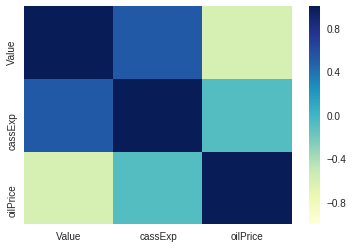

In [296]:
exp = expTS.reindex(prrTS.index, method='nearest', tolerance='10Days')
comp = prrTS.assign(cassExp=exp)

oil = crude_oilTS.reindex(prrTS.index, method='nearest', tolerance='10Days')
comp = comp.assign(oilPrice=oil)

print (comp.corr())
corr = comp.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [297]:
from google.colab import files
uploaded = files.upload()

Saving USA-Industrial.csv to USA-Industrial (6).csv


In [298]:
print (uploaded['USA-Industrial.csv'][:200].decode('utf-8') + '...')

Dates,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months
12/31/2000,272910496,0.0600,5.71,125571472
3/31/2001,231851504,0.0620,5.76,107048416
6/30/2001,228991248,0.0670,5.79,-225...


In [0]:
indDB = pd.read_csv(io.StringIO(uploaded['USA-Industrial.csv'].decode('utf-8')))
indDB['Dates'] = pd.to_datetime(df.Dates)

In [308]:
indTS = indDB.set_index('Dates').dropna()
indTS.head()
#indTS['Dates'] =pd.to_datetime(df.Dates)
#ind = indTS.reindex(prrTS.index, method='nearest', tolerance='10Days')

,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months
Dates,,,,
2000-12-31,272910496.0,0.060,5.71,125571472
2001-03-31,231851504.0,0.062,5.76,107048416
2001-06-30,228991248.0,0.067,5.79,-2257674
2001-09-30,220636624.0,0.071,5.81,59437404
2001-12-31,187257024.0,0.077,5.81,39837552


In [0]:
testTS = indTS.reindex(prrTS.index, method='nearest', tolerance='10Days').dropna()

In [310]:
test = testTS.assign(Expenditures = comp['cassExp'])
test = test.assign(PRRatio = comp['Value'])
test = test.assign(OilPrice = comp['oilPrice'])
test

,Under Construction Stock,Vacancy,Asking Rent,Net Absorption 12 Months,Expenditures,PRRatio,OilPrice
Date,,,,,,,
2018-06-30,258298896.0,0.049,8.14,251387872.0,2.894,12.24,75.68
2018-03-31,252588592.0,0.049,8.02,263907072.0,2.723,11.96,66.08
2017-12-31,248533584.0,0.050,7.90,273733472.0,2.638,11.86,64.84
2017-09-30,254380160.0,0.051,7.77,265657504.0,2.507,11.46,55.20
2017-06-30,254617728.0,0.051,7.66,289390496.0,2.497,11.40,45.63
2017-03-31,255178464.0,0.052,7.55,278364960.0,2.355,11.46,50.43
2016-12-31,246754464.0,0.052,7.43,285354976.0,2.274,11.35,53.30
2016-09-30,230304736.0,0.054,7.32,294107936.0,2.396,11.09,44.63
2016-06-30,215696416.0,0.057,7.21,267689632.0,2.370,10.93,46.27


In [0]:
test_nor = (test - test.min()) / (test.max() - test.min())

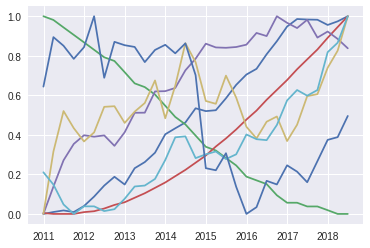

In [312]:
plt.plot(test_nor)

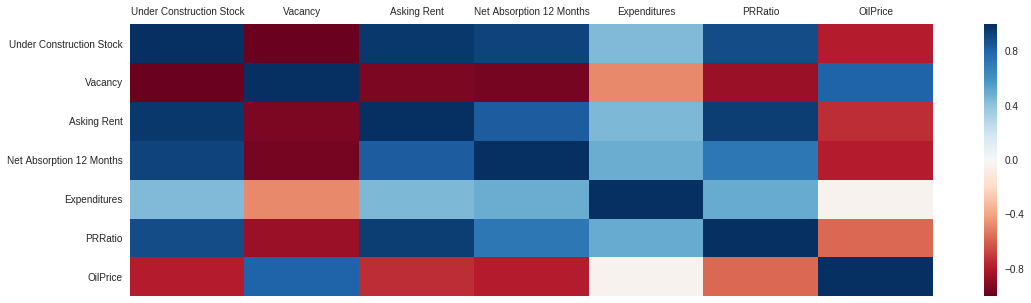

In [334]:
test_nor.corr()

corr = test_nor.corr()
plt.figure(figsize = (18,5))
ax = sns.heatmap(corr, cmap="RdBu")
ax.xaxis.tick_top()
plt.show()

In [0]:
seq_len = 150
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.2
decay = 0.5
epochs = 10